In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn as skl

from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout

from sklearn.metrics import average_precision_score, mean_squared_error, roc_curve, auc
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

base_path = "d:/work/stackoverflow/"
base_path_nn = base_path + "exp/nn/"

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/device:GPU:0']

In [3]:
def data_divider(data, per=0.8, shuffle=True):
    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    rr = round(len(data.index) * per)
    return data[:rr], data[rr:]

def get_norms(ser):
    return normalize(ser[:,np.newaxis], axis=0).ravel()

In [4]:
data = pd.read_csv(base_path + 'text.csv')
data = data[:10000]

data['title_overlap'] = get_norms(data['title_overlap'])
data['ans_count'] = get_norms(data['ans_count'])
data['questions_count'] = get_norms(data['questions_count'])
data['reached_people'] = get_norms(data['reached_people'])
data['user_rating'] = get_norms(data['user_rating'])

data = data.drop(['id_post', 'id_user', 'title_overlap'], axis=1)

train_data, test_data = data_divider(data)
x_train = train_data.drop('post_type', axis=1)
y_train = train_data['post_type']
x_test = test_data.drop('post_type', axis=1)
y_test = test_data['post_type']

data[:5]

,ans_count,questions_count,reached_people,user_rating,debug_inf,post_type
0,0.000000,0.000348,0.000001,7.455471e-07,0,1
1,0.000524,0.002524,0.000498,2.594504e-04,0,0
2,0.016703,0.043173,0.017964,1.318500e-02,0,1
3,0.000000,0.000696,0.000003,1.416539e-05,0,1
4,0.000000,0.000174,0.000001,7.455471e-07,0,0


In [5]:
classifier = Sequential()

classifier.add(Dense(output_dim = 6, init = 'uniform', activation = 'relu', input_dim = x_train.shape[1]))
classifier.add(Dropout(0.2, noise_shape=None, seed=None))

#classifier.add(Dense(output_dim = 15, init = 'uniform', activation = 'relu'))
#classifier.add(Dropout(0.2, noise_shape=None, seed=None))

#classifier.add(Dense(output_dim = 12, init = 'uniform', activation = 'relu'))
#classifier.add(Dropout(0.4, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 5, init = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.3, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 4, init = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2, noise_shape=None, seed=None))

classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

d:\programs\python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=5, units=6, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
d:\programs\python3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=5, kernel_initializer="uniform")`
  if sys.path[0] == '':
d:\programs\python3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=4, kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
d:\programs\python3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


In [6]:
classifier.summary()

history = classifier.fit(x_train, y_train, validation_split=0.2, batch_size = 30, nb_epoch = 50)

classifier.save("model_tmp.ser")

d:\programs\python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 36        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 35        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 24        
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

Epoch 48/50
6400/6400 [==============================] - 1s 168us/step - loss: 0.5202 - accuracy: 0.7836 - val_loss: 0.5206 - val_accuracy: 0.7844
Epoch 49/50
6400/6400 [==============================] - 1s 157us/step - loss: 0.5206 - accuracy: 0.7836 - val_loss: 0.5209 - val_accuracy: 0.7844
Epoch 50/50
6400/6400 [==============================] - 1s 156us/step - loss: 0.5207 - accuracy: 0.7836 - val_loss: 0.5206 - val_accuracy: 0.7844


In [7]:
def eval_res(res, goal, hist=None):
    all_c = len(goal.index)
    right = 0
    for i in range(len(goal)):
        if res[i] == goal.iloc[i]:
            right += 1
    acc = right / all_c
    print('accuracy: {}'.format(acc))

    average_precision = average_precision_score(goal, res)
    f1_score = skl.metrics.f1_score(res, goal)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print('F1 score: {}'.format(f1_score))

    fpr, tpr, thresholds = roc_curve(goal, res)
    au_curve = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {:.3f}'.format(au_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    if hist != None:
        plt.figure(2)
        #plt.subplot(211)
        plt.title('Loss')
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='test')
        plt.legend()

        plt.figure(3)
        #plt.subplot(212)
        plt.title('Accuracy')
        plt.plot(hist.history['accuracy'], label='train')
        plt.plot(hist.history['val_accuracy'], label='test')
        plt.legend()
        plt.show()

Train: 0.784, Test: 0.788
accuracy: 0.788
Average precision-recall score: 0.79
F1 score: 0.8814317673378076


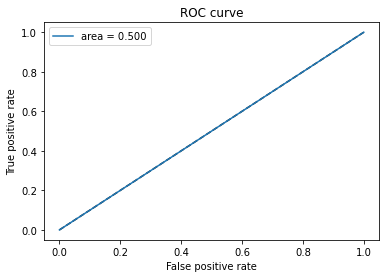

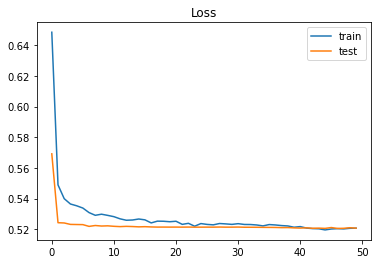

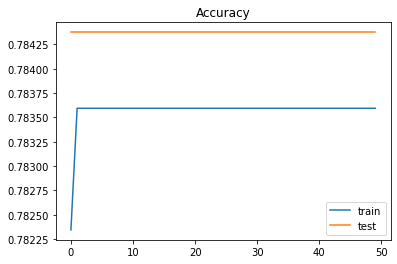

In [8]:
prediction = classifier.predict(x_test).tolist()
plot_model(classifier, to_file="model.png")

res = []
for i in prediction:
    if i[0] >= 0.5:
        res.append(1)
    else:
        res.append(0)
        
_, train_acc = classifier.evaluate(x_train, y_train, verbose=0)
_, test_acc = classifier.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

eval_res(res, y_test, history)

accuracy: 0.788
Average precision-recall score: 0.79
F1 score: 0.8814317673378076


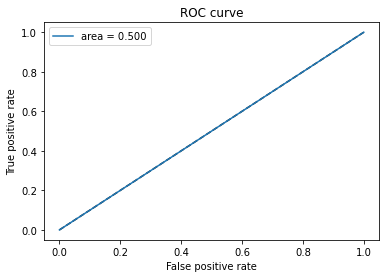

In [9]:
log_reg = LogisticRegression(random_state=0)
log_reg.fit(x_train, y_train)
res = log_reg.predict(x_test).tolist()

eval_res(res, y_test)

accuracy: 0.788
Average precision-recall score: 0.79
F1 score: 0.8814317673378076


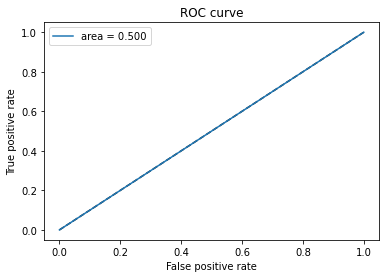

In [10]:
eval_res([1 for i in range(len(y_test))], y_test)

accuracy: 0.793
Average precision-recall score: 0.82
F1 score: 0.8786635404454864


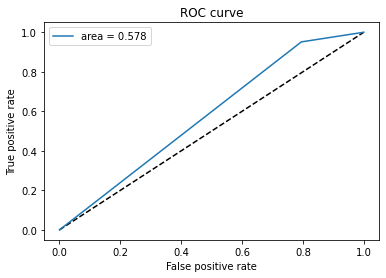

In [11]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
res = model.predict(x_test)
eval_res(res, y_test)

accuracy: 0.8135
Average precision-recall score: 0.82
F1 score: 0.892040520984081


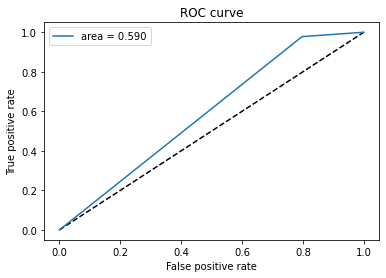

In [12]:
model = xgb.XGBRFRegressor()
model.fit(x_train, y_train)
prediction = model.predict(x_test)
res = []
for i in prediction:
    if i >= 0.5:
        res.append(1)
    else:
        res.append(0)
eval_res(res, y_test)

In [13]:
#kf = KFold(n_splits=2)
#for train_index, test_index in kf.split(x_train, y_train):
    #print("{} {}".format(train_index, test_index))
    #kk = [z for z in x_train.index]
    #xgb_regr = xgb.XGBRFRegressor(random_state=10).fit(x_train[kk == train_index], y_train[kk == train_index])